<a href="https://colab.research.google.com/github/prawizard/CE888_Repo/blob/main/Lab_4/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages/libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the data files

In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)

In [3]:
test_data=pd.DataFrame(data)
test_data=pd.concat([test_data.loc[:, 0], test_data.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
test_data.drop(columns=[0], inplace=True)

In [5]:
data=pd.concat([data.loc[:, 0], data.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
data.drop(columns=[0], inplace=True)

In [16]:
val_data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_data.drop(columns=[0], inplace=True)
# val_data.head()

# Highest and lowest rated joke

In [180]:
print('Joke with highest rating : ', test_data.max(axis=0).idxmax())
print('Joke with lowest rating : ', test_data.min(axis=0).idxmin())

Joke with highest rating :  45
Joke with lowest rating :  1


In [ ]:
# val_data=pd.DataFrame(data)
# val_data.drop(columns=[0], inplace=True)

# Prepare Validation Data

In [17]:
arr = val_data.values
arr.shape

(24983, 100)

In [19]:
rated = np.where(arr!=99)
print(len(rated[0]), rated[1].shape)

1810455 (1810455,)


In [ ]:
# data.drop(columns=[0], inplace=True)

In [35]:
len(np.where(arr!=99)[1])

1810455

In [21]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [36]:
new_arr, idx = replace(arr, 0.1)

In [37]:
arr[idx[0][0], idx[1][0]]

-4.71

In [38]:
new_arr[idx[0][0], idx[1][0]]

99.0

In [39]:
val_data=pd.DataFrame(new_arr)
val_data=pd.DataFrame(val_data.loc[:, 0:].replace(99.00, np.NaN))
val_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,NaN,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,NaN,-8.50,1.12,7.82,2.86,NaN,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,NaN,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,NaN,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,NaN,7.72,8.98,8.64,8.20,3.93,NaN,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,NaN,9.27,NaN,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,NaN,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,NaN,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.5,4.61,-4.17,NaN,1.36,1.60,NaN,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,NaN,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,NaN,5.92,0.87,7.28,3.93,NaN,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


# Training

In [189]:
n_latent_factors = 2

user_ratings = data.values
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [190]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 2) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [191]:
num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations

Iteration 0/10:	MSE=26.197981
Iteration 2/10:	MSE=24.941956
Iteration 4/10:	MSE=24.475073
Iteration 6/10:	MSE=24.002070
Iteration 8/10:	MSE=23.524682


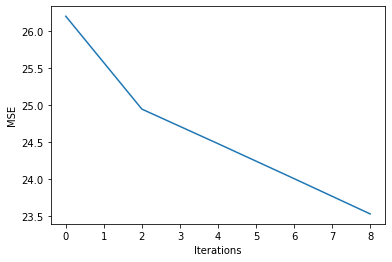

In [192]:
plt.figure()
plt.plot(np.arange(0, num_iter, 2), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

# Predicting

In [193]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[0.89621365, 0.57672886, 0.60527279, ..., 1.09508259, 0.47401317,
        1.3894225 ],
       [0.76350981, 0.49618581, 0.42153811, ..., 0.73612802, 0.32282567,
        1.21123716],
       [1.7924897 , 1.15744737, 1.13401617, ..., 2.03011575, 0.88215559,
        2.80135627],
       ...,
       [1.33294943, 0.85707498, 0.91381747, ..., 1.65714453, 0.71670041,
        2.06252741],
       [1.5393378 , 0.99572314, 0.94010302, ..., 1.67281192, 0.72851547,
        2.41560448],
       [1.94316325, 1.25184515, 1.28547143, ..., 2.3181461 , 1.00461972,
        3.02040211]])

# Predicting on Validation set

In [194]:
val_data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_data.drop(columns=[0], inplace=True)
val_data=pd.DataFrame(val_data.loc[:, 0:].replace(99.00, np.NaN))

v_data=pd.DataFrame(new_arr)
v_data=pd.DataFrame(v_data.loc[:, 0:].replace(99.00, np.NaN))

v_user_ratings=v_data.values

v_values = [zip(v_user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
v_comparison_data = pd.DataFrame(v_values)
v_comparison_data.columns = data.columns

# v_comparison_data

In [195]:
val_user_ratings=val_data.values

error = []

for user_id in range(latent_user_preferences.shape[0]):
    for item_id in range(latent_item_features.shape[0]):
        rating = val_user_ratings[user_id, item_id]
        
        if not np.isnan(rating):
             val_predicted_rating = predict_rating(user_id, item_id)
             err =  val_predicted_rating - rating
             
            #  err = train(user_id, item_id, rating)
             error.append(err)
val_mse = (np.array(error) ** 2).mean()
print('MSE on Validation Set :', val_mse)

MSE on Validation Set : 23.157604369848936


# Predicting on Test Set

In [196]:
test_user_ratings=test_data.values
values = [zip(test_user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = data.columns
comparison_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(-7.82, 0.8962136462665519)","(8.79, 0.5767288635993157)","(-9.66, 0.6052727861801858)","(-8.16, -0.46175887417391953)","(-7.52, 0.6156338947480964)","(-8.5, 1.53745873833349)","(-9.85, 0.03568762616017679)","(4.17, -0.24463416495151685)","(-8.98, -0.020268890442969374)","(-4.76, 1.1164378101574715)","(-8.5, 1.630006674295079)","(-6.75, 1.5233630449702529)","(-7.18, -0.9767828466795299)","(8.45, 1.4888396660423338)","(-7.18, -1.0146828303871098)","(-7.52, -1.8971588572047924)","(-7.43, -0.4481436881905043)","(-9.81, -0.23798567881349547)","(-9.85, 0.4178570745056873)","(-9.85, -0.23586527614531363)","(-9.37, 1.9305201798937979)","(1.5, 1.0546451365405167)","(-4.37, 0.4826560661950871)","(-9.81, -0.7287094626260407)","(-8.5, 0.7593353513824724)","(1.12, 1.4194773194969215)","(7.82, 2.512923058603568)","(2.86, 1.4775474577661405)","(9.13, 2.3628765215751906)","(-7.43, 0.23922594818874676)","(2.14, 1.944162632954412)","(-4.08, 2.471059557282392)","(-9.08, -0.42408394846317055)","(7.82, 1.129046041586181)","(5.05, 2.408965309489686)","(4.95, 2.5311109340097797)","(-9.17, -0.5552751056178817)","(-8.4, 1.2437503307754465)","(-8.4, 1.2777246176709511)","(-8.4, 1.1827964656427092)",...,"(8.59, 2.1317143634145874)","(3.59, 2.3623158616412576)","(-6.84, 0.648442226304221)","(-9.03, -0.0606712424362652)","(2.82, 2.0438868590997923)","(-1.36, 2.1418780864025755)","(-9.08, -0.1711004405942607)","(8.3, 2.1775323226776138)","(5.68, 2.2042111845605183)","(-4.81, 0.7982342073133148)","(nan, -0.014977778446257157)","(nan, 2.2187901960840337)","(nan, 1.2018000138661724)","(nan, -0.48553077304257936)","(nan, 0.28915928061505347)","(nan, 2.0360329035476212)","(nan, 0.9362388705270525)","(-9.42, 1.6035770560934768)","(nan, 0.6514568575467026)","(nan, 1.3175124840010874)","(nan, 1.598839635342587)","(-7.72, 1.0507926259094857)","(nan, 1.787788933462462)","(nan, 0.9010251844436953)","(nan, 1.1030655038598307)","(nan, 0.5710923834319528)","(nan, 1.6485159192235765)","(nan, 1.727756012025878)","(nan, 2.6397512668717136)","(nan, 0.8633879171395363)","(2.82, 1.6904167140768322)","(nan, 1.2261603060104078)","(nan, 2.025767867595851)","(nan, 1.096506686381491)","(nan, 1.1093425491539792)","(nan, 1.3866113018999784)","(-5.63, 1.4780261566415818)","(nan, 1.0950825921686111)","(nan, 0.47401317177823366)","(nan, 1.3894225045350959)"
1,"(4.08, 0.7635098052338583)","(-0.29, 0.4961858070893432)","(6.36, 0.42153810811003434)","(4.37, -0.5461778178407407)","(-2.38, 0.4361144783383537)","(-9.66, 1.2654280575237329)","(-0.73, -0.0801699125718736)","(-5.34, -0.25859867757896404)","(8.88, 0.003017949984553358)","(9.22, 0.9456672683358905)","(6.75, 1.381978583042294)","(8.64, 1.233351021308492)","(4.42, -0.7932822090010282)","(7.43, 1.2562353555631485)","(4.56, -0.8552101029637671)","(-0.97, -1.634216033506132)","(4.66, -0.4214328187583657)","(-0.68, -0.11877567024457483)","(3.3, 0.3830394007084521)","(-1.21, -0.3195851134460975)","(0.87, 1.6087647503799707)","(8.64, 0.8284124636857897)","(8.35, 0.36048378147956267)","(9.17, -0.7078196586059422)","(0.05, 0.5574081601912652)","(7.57, 1.1157486464218997)","(4.71, 2.094205742846258)","(0.87, 1.1927548840011577)","(-0.39, 2.014838919789672)","(6.99, 0.03776554439952153)","(6.5, 1.673601698054475)","(-0.92, 2.146375799677036)","(7.14, -0.4458295533550019)","(9.03, 0.91725350598857)","(-1.8, 2.082441168301575)","(0.73, 2.1487380217327874)","(7.09, -0.48605421345639704)","(3.4, 1.0077864213098484)","(-0.87, 1.0026816880798328)","(7.91, 0.9106994873429306)",...,"(-6.7, 1.7811562722083418)","(-3.35, 2.10188442229904)","(-9.03, 0.4933315637721156)","(4.47, -0.13487533032030238)","(4.08, 1.6731063343786583)","(-3.83, 1.7801747295962933)","(8.74, -0.1336119517921721)","(1.12, 1.803276366834458)",

In [58]:
# while 1: pass

# For Quiz

In [70]:
quiz_users=pd.read_excel('movies_latent_factors.xlsx', sheet_name='Users')
quiz_items=pd.read_excel('movies_latent_factors.xlsx', sheet_name='Items')

In [63]:
# quiz_movies

In [232]:
test_data.loc[8243, 61]

-1.02

In [233]:
comparison_data.loc[8243, 61]

(-1.02, 3.7707899520837618)

In [230]:
comparison_data.loc[23437, 58]

(nan, -0.5170951318240115)

In [198]:
quiz_users.loc[quiz_users['User']==4327, 'Factor14']

21   -0.09349
Name: Factor14, dtype: float64

In [199]:
round(-0.09349, 3)

-0.093

In [77]:
quiz_items.loc[quiz_items['Movie ID']==629, 'Factor12']

53    0.452338
Name: Factor12, dtype: float64

In [87]:
(quiz_items.loc[quiz_items['Factor5']==np.max(quiz_items['Factor5']), ['Movie ID', 'Factor5']])

,Movie ID,Factor5
15,121,2.750878


In [89]:
quiz_items.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [203]:
np.argmin(quiz_items.loc[:, 'Factor3'].values)

47

In [205]:
quiz_items.loc[47, ['Title', 'Factor3']]

Title      Titanic (1997)
Factor3          -2.52338
Name: 47, dtype: object

In [110]:
a=quiz_items.loc[quiz_items['Movie ID']==8358]

In [111]:
a=a.values.squeeze()

In [112]:
a=a[2:]
a

array([0.1254612435522293, -0.1846836856931454, -1.3257366317768604,
       -0.33872401288259174, 0.5344138950050794, -0.19292569791749567,
       -0.42831016818184303, 0.08639926748549187, -0.33228588544004956,
       0.15839832717803923, 0.01295686912424204, 0.4678236973410492,
       0.16033537589107677, -0.7588670152539986, 0.4766352511552939],
      dtype=object)

In [211]:
b=quiz_users.loc[quiz_users['User']==3878]

In [212]:
b=b.values.squeeze()

In [213]:
b=b[1:]
b

array([-0.09146183,  0.2158788 , -0.18045275,  0.0854081 , -0.32109377,
        0.22794667,  0.05376719,  0.03801749,  0.09714137, -0.13987159,
        0.02925282,  0.21446732,  0.18925022,  0.06598962,  0.10277606])

In [139]:
quiz_pred=np.dot(b, a.T)

In [142]:
round(quiz_pred, 2)

-0.02

In [214]:
c=quiz_items.loc[quiz_items['Movie ID']==197]
c=c.values.squeeze()
c=c[2:]
c

array([-0.6880903520483415, -1.0785096340532638, -1.331394869897539,
       -0.4773289748383014, 0.7395697351329814, 0.6382104977547886,
       0.06771889989090495, 0.39080939755470473, -0.049157936178380664,
       0.5860527130653354, -1.0852360002809158, 0.49648172827053944,
       1.1235452510306585, -1.5321012682387738, -0.18185329170885758],
      dtype=object)

In [215]:
quiz_pred=np.dot(b, c.T)
round(quiz_pred, 2)

0.04

In [223]:
u_2067=quiz_users.loc[quiz_users['User']==4433]
u_2067=u_2067.values.squeeze()
u_2067=u_2067[1:]
u_2067

array([-0.29876022, -0.29022829, -0.16011999,  0.15627653, -0.05536439,
       -0.43420511, -0.08925945,  0.25221114, -0.10741343, -0.08859105,
        0.12115684,  0.07137071, -0.41559848, -0.02213915, -0.18302114])

In [224]:
all_item_factors=quiz_items.values[:, 2:]

In [225]:
quiz_ratings=np.dot(u_2067, all_item_factors.T)

In [226]:
np.argmax(quiz_ratings)

2

In [227]:
np.argsort(quiz_ratings)[::-1][:3]

array([ 2, 27, 50])

In [228]:
quiz_items.loc[np.argsort(quiz_ratings)[::-1][:3], :]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
27,238,The Godfather (1972),-2.611462,0.005551,-1.055331,0.150950,0.233674,0.266476,0.605631,0.595702,-0.112474,-1.488997,-0.378031,0.303310,-0.591693,0.400705,-2.267831
50,603,The Matrix (1999),-3.063639,-1.319283,-0.043618,-0.994612,-0.954054,0.190838,0.197918,-0.093962,-1.082840,-0.003843,1.377453,-1.668189,-1.348377,0.223797,0.752413


In [174]:
u_4940=quiz_users.loc[quiz_users['User']==4940]
u_4940=u_4940.values.squeeze()
u_4940=u_4940[1:]
u_4940

array([-0.11309877,  0.04764329, -0.0530243 ,  0.02483359,  0.0106429 ,
       -0.01205102, -0.04915036,  0.0062524 ,  0.02042851,  0.00434913,
        0.02837151,  0.01022704, -0.00823291, -0.02930419,  0.09051074])

In [175]:
quiz_ratings=np.dot(u_4940, all_item_factors.T)
np.argsort(quiz_ratings)[::-1][:3]

array([ 2, 33, 50])

In [176]:
quiz_items.loc[np.argsort(quiz_ratings)[::-1][:3], :]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
33,278,The Shawshank Redemption (1994),-2.780308,-0.088747,-1.821590,-0.157495,0.323285,-0.114768,0.281397,-0.130262,0.028689,-0.810090,-0.229137,0.587575,0.194144,-0.976664,-0.779991
50,603,The Matrix (1999),-3.063639,-1.319283,-0.043618,-0.994612,-0.954054,0.190838,0.197918,-0.093962,-1.082840,-0.003843,1.377453,-1.668189,-1.348377,0.223797,0.752413


In [188]:
np.average(data.loc[:, 45].values[~np.isnan(data.loc[:, 45].values)])

1.1086161781946073